In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras

from pysster.One_Hot_Encoder import One_Hot_Encoder
from sklearn import preprocessing
from keras.utils import to_categorical
import logomaker as lm

import os
import glob
from collections import OrderedDict
import random
from random import shuffle
from scipy.stats import sem, t
from scipy import mean

import matplotlib
import matplotlib.font_manager as fm
fpath = '/Library/Fonts/Myriad-Pro_31655.ttf'
prop = fm.FontProperties(fname=fpath)
fname = os.path.split(fpath)[1]
axis_font = {'fontname':fname, 'fontproperties':prop}

Using TensorFlow backend.


# Part 1: Read in all csv files

In [2]:
def strip_f_of_weird_other_stuff(filename):
    first_strip = filename.partition("csv_files/")[2]
    second_strip = first_strip.partition("_filter")[0]
    return second_strip

In [3]:
path ='twenty_models/csv_files/'
filenames = glob.glob(path + "/*.csv")

dict_of_df = OrderedDict((strip_f_of_weird_other_stuff(f), pd.read_csv(f, usecols=range(1,5))) for f in filenames)

# Part 2: Get sequences from each pwm

In [4]:
all_pwms = dict_of_df.values()
filt_width = 5
num_nucleotides = 4
alph_letters = sorted('AUCG')
alph = list(alph_letters)

list_of_seqs = []

for mat in all_pwms:
    seq = ''
    for row in range(0, len(mat.index)):
        curr_row = mat.iloc[row,:]
        max_col = curr_row.idxmax(axis=1) # to get the minimum, use max_col = curr_row.idxmin(axis=1)- SUPP
        seq = seq + max_col
    list_of_seqs.append(seq)

#print(list_of_seqs)

In [5]:
# break up filter into 3mer and make a dictionary so we can investigate occurrences
threemer_dict = {}

for seq in list_of_seqs:
    for i in range (0, 3):
        mer = seq[i:(i+3)]
        if mer in threemer_dict:
            threemer_dict[mer] = threemer_dict.get(mer) + 1
        else:
            threemer_dict[mer] = 1

#print(threemer_dict)

In [6]:
# sort dictionary by key
keys = []
values = []
for key in sorted(threemer_dict.keys()):
    keys.append(key)
    values.append(threemer_dict[key])

In [7]:
def switch_DNA_to_RNA(seq):
    new_kmer = []
    for char in seq:
        if char is 'T':
            new_kmer.append('U')
        else:
            new_kmer.append(char)
    return "".join(new_kmer)

def shuffle_word(word):
    word = list(word)
    shuffle(word)
    return ''.join(word)

In [8]:
# get an intelligent null distribution (not just uniform)
# load in the regular toeholds
data_dir ='../../data/'
file_name = 'newQC_toehold_data.csv'
data_df = pd.read_csv(data_dir + file_name,sep=',')
data_df.head(3)

qc_cutoff=1.1
data_df = data_df[data_df['on_qc'] >= qc_cutoff].reset_index()
data_df = data_df[data_df['off_qc'] >= qc_cutoff].reset_index()
toehold_seqs = data_df['switch_sequence']
seq_len = len(toehold_seqs[0])
print('Number of remaining sequences: ', len(data_df))

# clean up matrix
data_df = data_df[['switch_sequence', 'on_value', 'off_value', 'onoff_value']]

# make empty array of 64 (# of possible kmers) x # bootstraps to fill in
num_bootstraps = 1000
kmer_len = 3
kmer_lib_size = 4 ** kmer_len
number_of_kmers_to_compare = 600

kmer_occurrences = np.zeros((kmer_lib_size,num_bootstraps))
scrambled_kmer_occurrences = np.zeros((kmer_lib_size,num_bootstraps))

# for i in range(0, number of bootstraps)
for i in range(0, num_bootstraps):
    for j in range(0, number_of_kmers_to_compare):
        # extract 600 kmers by randomly generating first the row # to extract the toehold from 
        get_rand_toehold = data_df.iloc[random.randrange(0, len(data_df)), data_df.columns.get_loc("switch_sequence")]
        # and second the position to start the kmer at
        get_rand_kmer_start = random.randrange(0, len(get_rand_toehold)-3)
        get_rand_kmer_in_toehold = get_rand_toehold[get_rand_kmer_start:get_rand_kmer_start+3]
        new_kmer = switch_DNA_to_RNA(get_rand_kmer_in_toehold)
        # now put the kmer into the proper position in the kmer_occurrences array
        kmer_index = keys.index(new_kmer)
        curr_kmer = kmer_occurrences[kmer_index, i]
        kmer_occurrences[kmer_index, i] = curr_kmer + 1
        
        # do same for scrambled dataset
        scrambled_toehold = shuffle_word(get_rand_toehold)
        get_scrambled_kmer_in_toehold = scrambled_toehold[get_rand_kmer_start:get_rand_kmer_start+3]
        scrambled_kmer = switch_DNA_to_RNA(get_scrambled_kmer_in_toehold)
        kmer_index = keys.index(scrambled_kmer)
        curr_kmer = scrambled_kmer_occurrences[kmer_index, i]
        scrambled_kmer_occurrences[kmer_index, i] = curr_kmer + 1

# then get the average and std dev of each kmer
avg_kmer_occurrence = np.mean(kmer_occurrences, axis = 1)
std_dev_kmer_occurrence = np.std(kmer_occurrences, axis = 1)

#print(avg_kmer_occurrence)
#print(std_dev_kmer_occurrence)

# then get the average and std dev of each kmer
avg_scrambled_kmer_occurrence = np.mean(scrambled_kmer_occurrences, axis = 1)
std_dev_scrambled_kmer_occurrence = np.std(scrambled_kmer_occurrences, axis = 1)

#print(avg_scrambled_kmer_occurrence)
#print(std_dev_scrambled_kmer_occurrence)

#print(keys)

Number of remaining sequences:  91534


In [9]:
def get_means_and_bounds_of_stds(matrix):
    
    means = []
    conf_int_lower_bound = []
    conf_int_upper_bound = []

    for row in matrix:
        confidence = 0.95 # compute 95% confidence interval
        n = len(row)
        m = mean(row)
        std_err = sem(row)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        means.append(m)
        conf_int_lower_bound.append(m-h)
        conf_int_upper_bound.append(m+h)
        
    return([means, conf_int_lower_bound, conf_int_upper_bound])

In [10]:
# make data frame

# make keys, r1, values (filters), means (toeholds), std devs (toeholds), means (scrambled), std devs (scrambled) into df
df = pd.DataFrame({'keys': keys, 'values': values})

# get toehold kmers
means, conf_int_lower_bound, conf_int_upper_bound = get_means_and_bounds_of_stds(kmer_occurrences)
df['toehold_mean'] = means
df['toehold_std'] = std_dev_kmer_occurrence

# get shuffled kmers
means, conf_int_lower_bound, conf_int_upper_bound = get_means_and_bounds_of_stds(scrambled_kmer_occurrences)
df['scrambled_mean'] = means
df['scrambled_std'] = std_dev_scrambled_kmer_occurrence

# reorder
df = df.sort_values('values', ascending = False).reset_index()
df['r1'] = list(range(0, len(df)))

threshold = 600 / 64

In [11]:
#add uniform distribution to the matrix
df['uniform'] = threshold

#add kl divergence to the matrix for values, toehold experimental data, and scrambled
df['fold_change_values'] = [((val - unif)/unif) for val, unif in zip(df['values'], df['uniform'])]
df['fold_change_toehold_exp'] = [((val - unif)/unif) for val, unif in zip(df['toehold_mean'], df['uniform'])]
df['fold_change_scrambled'] = [((val - unif)/unif) for val, unif in zip(df['scrambled_mean'], df['uniform'])]

#df

,index,keys,values,toehold_mean,toehold_std,scrambled_mean,scrambled_std,r1,uniform,fold_change_values,fold_change_toehold_exp,fold_change_scrambled
0,21,CCC,32,3.718,1.859698,3.019,1.662720,0,9.375,2.413333,-0.603413,-0.677973
1,60,UUA,21,9.473,3.056022,13.084,3.612055,1,9.375,1.240000,0.010453,0.395627
2,12,AUA,16,11.361,3.314314,17.766,4.132704,2,9.375,0.706667,0.211840,0.895040
3,37,GCC,16,3.801,1.966570,4.740,2.160648,3,9.375,0.706667,-0.594560,-0.494400
4,63,UUU,15,13.471,3.578430,9.013,3.082666,4,9.375,0.600000,0.436907,-0.038613
5,53,UCC,14,7.064,2.725785,4.252,2.019529,5,9.375,0.493333,-0.246507,-0.546453
6,51,UAU,14,11.722,3.412435,13.119,3.573351,6,9.375,0.493333,0.250347,0.399360
7,38,GCG,13,1.650,1.257577,6.648,2.591543,7,9.375,0.386667,-0.824000,-0.290880
8,29,CUC,13,6.164,2.480142,4.277,2.136415,8,9.375,0.386667,-0.342507,-0.543787
9,25,CGC,13,1.475,1.206389,4.680,2.188059,9,9.375,0.386667,-0.842667,-0.500800


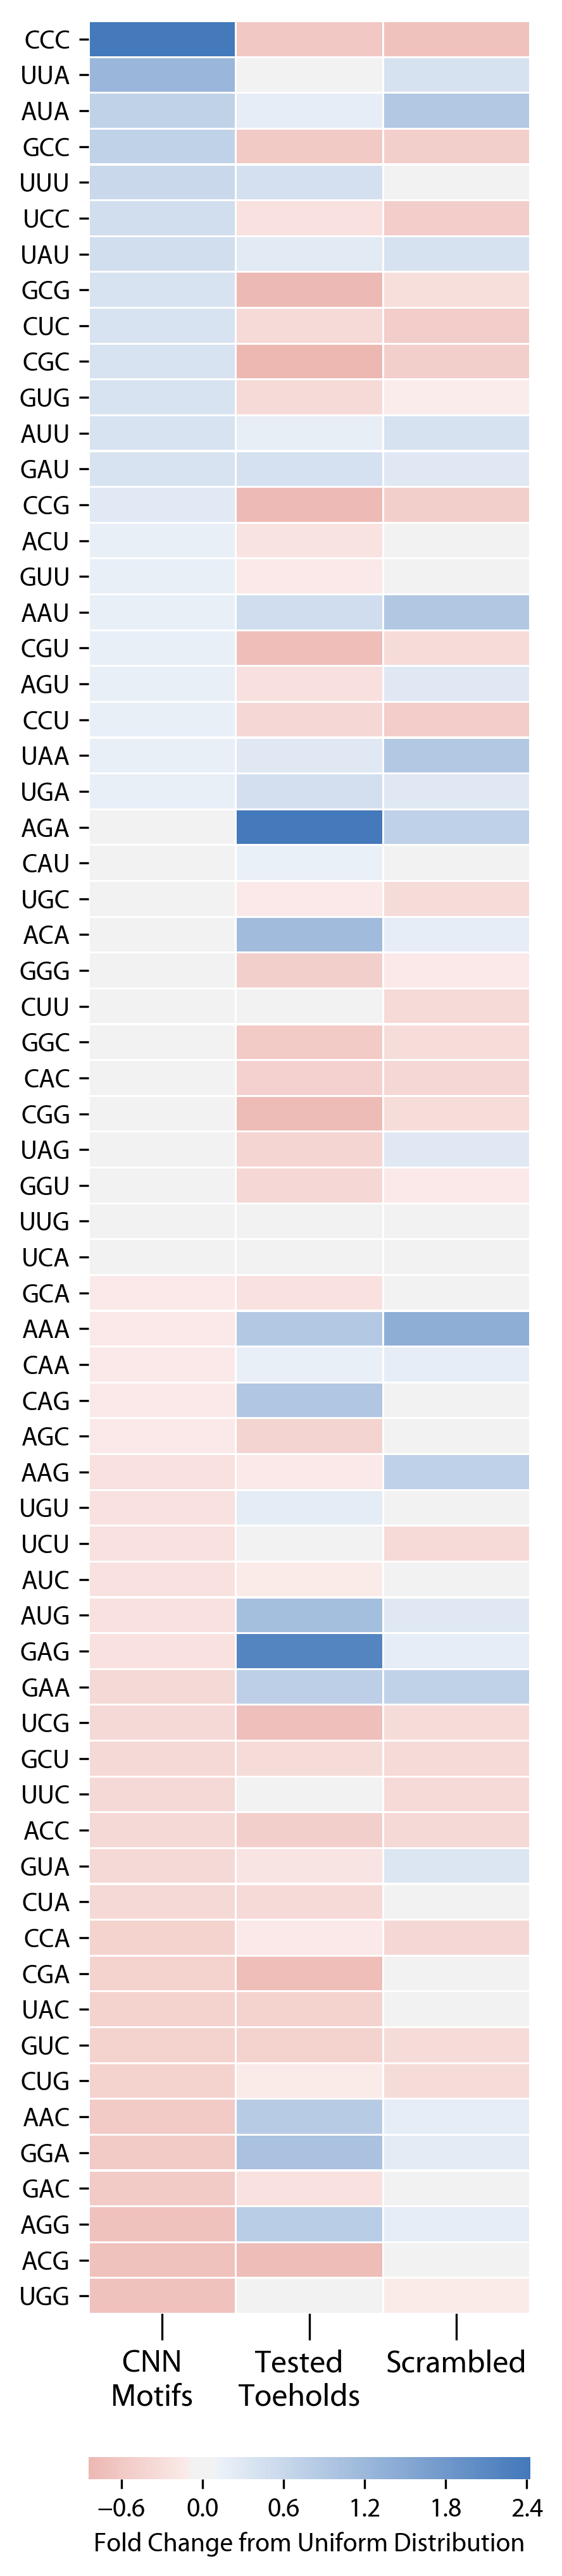

In [12]:
fig, ax = plt.subplots(figsize = (3, 20), dpi = 300)

fold_changes = df.loc[:,['fold_change_values', 'fold_change_toehold_exp', 'fold_change_scrambled']]
cmap = sns.diverging_palette(15, 250, sep=10, as_cmap = True)
xticklabels = ['CNN   \nMotifs   ', 'Tested   \nToeholds   ', 'Scrambled']

g = sns.heatmap(fold_changes, center = 0, yticklabels = df['keys'], cmap = cmap, linecolor = 'white', linewidths=0.5, 
           xticklabels = xticklabels, ax = ax, cbar_kws={"orientation": "horizontal", "pad": 0.05})
g.set_xticklabels(g.get_xticklabels(), rotation = 0, **axis_font, fontsize = 12)
g.set_yticklabels(g.get_yticklabels(), **axis_font)
g.tick_params(axis ='x', which ='both', length = 10) 
ax.collections[0].colorbar.set_label("Fold Change from Uniform Distribution", **axis_font)
ax.collections[0].colorbar.ax.set_xticklabels(ax.collections[0].colorbar.ax.get_xticklabels(), **axis_font)
plt.show()